In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import load_img
import itertools
import shutil
import glob
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import pandas as pd
from tensorflow.keras import optimizers

## Unzip

In [2]:
test1= zipfile.ZipFile('../input/dogs-vs-cats/test1.zip')
test1.extractall()
train= zipfile.ZipFile('../input/dogs-vs-cats/train.zip')
train.extractall()

In [3]:
import pathlib

path = pathlib.Path("train")
new_dir = pathlib.Path("train_validation")

def seperating(subset_name, start, end):
    category = ["cat","dog"]
    for k in category:
        dir = new_dir / subset_name / k
        try:
            os.makedirs(dir)
        except OSError:
            print(f"This file {dir} exist.")

        fnames = [f"{k}.{i}.jpg" for i in range(start, end)]
        for fname in fnames:
            shutil.copyfile(src=path / fname,
                            dst=dir / fname)

seperating("validation", start=0, end=200)
seperating("train", start=201, end=701)
seperating("test", start=800, end=900)


**So we have validation, train and test sets.**

In [4]:
pth_validation = "./train_validation/validation"
pth_train = "./train_validation/train"
pth_test = "./train_validation/test"


path, dirs, files = next(os.walk(pth_test))
print(len(files))


0


In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_btch = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=pth_train, target_size=(224,224), classes = ["cat","dog", "unknown_class"], batch_size=10)

test_btch = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=pth_test, target_size=(224,224), classes = ["cat","dog", "unknown_class"], batch_size=10, shuffle=False)

validation_btch = ImageDataGenerator(preprocessing_function= tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory=pth_validation, target_size=(224,224), classes = ["cat","dog","unknown_class"], batch_size=10)

Found 1000 images belonging to 3 classes.
Found 200 images belonging to 3 classes.
Found 400 images belonging to 3 classes.


In [6]:
img, label = next(train_btch)

## train

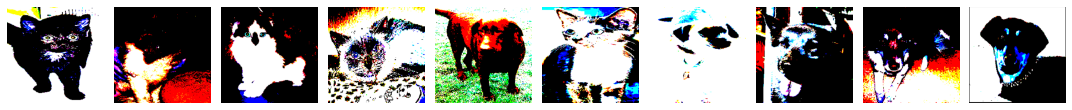

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [7]:
def plotImg(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImg(img)
print(label)    

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Training 


In [9]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 14s 0us/step


In [10]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
from keras.models import Model

model = Sequential()

for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [28]:
for layer in model.layers:
    layer.trainable = False
model.add(Dense(3, activation="softmax"))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [30]:

model.compile(loss="categorical_crossentropy",optimizer=optimizers.RMSprop(lr=1e-3),
              metrics=["accuracy"])

In [31]:
model.fit(x=train_btch,validation_data=validation_btch, epochs=5, verbose=2)

Epoch 1/5
100/100 - 154s - loss: 1.0326 - accuracy: 0.4900 - val_loss: 0.9887 - val_accuracy: 0.4975
Epoch 2/5
100/100 - 152s - loss: 0.9548 - accuracy: 0.4860 - val_loss: 0.9202 - val_accuracy: 0.4975
Epoch 3/5
100/100 - 152s - loss: 0.8941 - accuracy: 0.4900 - val_loss: 0.8677 - val_accuracy: 0.5025
Epoch 4/5
100/100 - 152s - loss: 0.8476 - accuracy: 0.4900 - val_loss: 0.8274 - val_accuracy: 0.5000
Epoch 5/5
100/100 - 152s - loss: 0.8128 - accuracy: 0.5000 - val_loss: 0.7977 - val_accuracy: 0.5000


## Result

In [32]:
model.save('./')
predictions =model.predict(x=test_btch,verbose=0)

In [ ]:
test_btch.classes

In [ ]:
cm = confusion_matrix(y_true=test_btch.classes, y_pred=np.argmax(predictions,axis=-1))


In [ ]:
test_btch.class_indices

## Result

In [ ]:
cm_labels = ["cat","dog"]
plot_confusion_matrix(cm=cm,classes = cm_labels, title = "CM after fine tuning")

In [ ]:
validation = os.listdir("./train_validation/validation")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
source_dir1 = './train_validation/test/cat'
source_dir2 = './train_validation/test/dog'
target_dir = './train_validation/test'
    
file_names = os.listdir(source_dir1)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir1, file_name), target_dir)
file_names = os.listdir(source_dir2)
for file_name in file_names:
    shutil.move(os.path.join(source_dir2, file_name), target_dir)
shutil.rmtree('./train_validation/test/cat', ignore_errors=True)
shutil.rmtree('./train_validation/test/dog', ignore_errors=True)

In [ ]:
test_filenames = os.listdir("./train_validation/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./train_validation/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=10,
    target_size=(224, 224),
    shuffle=False
)

In [ ]:
test_generator

In [ ]:
predictions_val =model.predict(x=validation_btch,steps=np.ceil(nb_samples/10))

In [ ]:
threshold = 0.5
test_df['category'] = np.where(predict > 0.5, 1,0)
test_df['category']

In [ ]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./train_validation/test/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()